## Import modules

In [1]:
import numpy as np
import os
from numpy import linalg as LA
import librosa
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv1D,MaxPooling1D,Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras import backend as K
import pandas as pd
import cv2
from PIL import Image
import time
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
#from pylab import *
import math

/Users/jaejinan/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load row datas

In [2]:
Datas=np.load("./npy/Datas.npy")

## 2. Mel Frequency Cepstral Coefficient (MFCC)

## Data processing

In [22]:
MFCCs = []
Label = []
file_static = []
for a in range(0,len(Datas)):
    for b in Datas[a]:
        mfcc = librosa.feature.mfcc(y=b, sr=44100,n_mfcc=20)
        MFCCs.append(mfcc)
        Label.append(a)

## Save and Load

In [23]:
MFCCs=np.array(MFCCs)
Label=np.array(Label)

In [24]:
np.save("./npy/MFCCs",MFCCs)
np.save("./npy/Label",Label)

In [25]:
MFCCs=np.load("./npy/MFCCs.npy")
Label=np.load("./npy/Label.npy")

## 2-1. Euclidean distance

In [26]:
MMFFCCs = []
for i in range(0,5):
    tmp = []
    for j in range(0,80):
        tmp.append(MFCCs[80*i+j])
    MMFFCCs.append(tmp)

MMFFCCss = []
for a in MMFFCCs:
    tmp = []
    for b in a:
        if(len(tmp) == 0):
            tmp.append(b)
        tmp = tmp + b
    tmp= tmp/80
    MMFFCCss.append(tmp)
    
MMFFCCs = np.array(MMFFCCs)
MMFFCCss = np.array(MMFFCCss)
#MMFFCCss[level_num][mfcc]
#level_num : 0~4(5 classes)
#mfcc : 20*18 dataset

#MMFFCCs[level_num][file_num][mfcc]
#level_num : 0~4(5 classes)
#file_num : 0~79(20*4 files)
#mfcc : 20*18 dataset

In [27]:
ED2 = []
for a in range(0,len(MMFFCCs)):
    tmp_1 = []
    for b in MMFFCCs[a]:
        tmp_2 = []
        for c in MMFFCCss:
            tmp_2.append(LA.norm(c-b))
        mm = min(tmp_2)
        for i in range(0,len(tmp_2)):
            if(tmp_2[i] == mm):
                tmp_2.append(i)
                if(i == a):
                    tmp_2.append(1)
                else:
                    tmp_2.append(0)
        tmp_1.append(tmp_2)
    ED2.append(tmp_1)
#ED2[level_num][file_num][distance&result]
#level_num : 0~4(5 classes)
#file_num : 0~79(20*4 files)
#static : {0~4:distance by level,5:result,6:T/F}

In [28]:
count = 0
for a in range(0,len(ED2)):
    cou = 0
    for b in ED2[a]:
        if(b[6]==1):
            cou = cou + 1
            count = count + 1
    print("level{0}:{1}".format(a,cou/len(ED2[0])*100))
print("all:{}".format(count/len(ED2[0])/5*100))

level0:62.5
level1:40.0
level2:46.25
level3:86.25
level4:52.5
all:57.49999999999999


In [29]:
from sklearn.metrics import confusion_matrix
test = []
for i in range(0,5):
    for j in range(0,80):
        test.append(i)
pred = []
for a in range(0,len(ED2)):
    for b in ED2[a]:
        pred.append(b[5])

print(confusion_matrix(test, pred))

[[50 18  8  0  4]
 [21 32 11  0 16]
 [11  8 37  2 22]
 [ 0  2  2 69  7]
 [ 6 12 12  8 42]]


## 2-2. Classifier

In [30]:
MFCCC = []
for a in MFCCs:
    tmp = []
    for b in range(0,len(a)):
        tmp.append(np.mean(a[b]))
    MFCCC.append(tmp)
MFCCC = np.array(MFCCC)

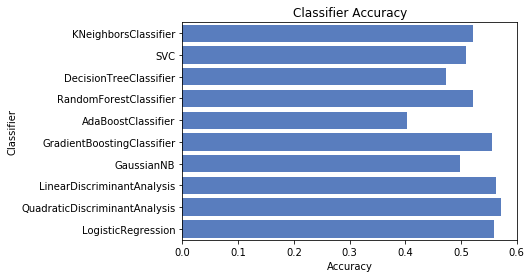

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

log_cols = ["Classifier", "Accuracy"]
log      = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

X = MFCCC
y = Label

acc_dict = {}

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_test)
        acc = accuracy_score(y_test, train_predictions)
        if name in acc_dict:
            acc_dict[name] += acc
        else:
            acc_dict[name] = acc

for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf] / 10.0
    log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
    log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")
#plt.savefig('./MFCC.pdf', dpi=600)

## 2-3. CNN

In [32]:
initialData = []
initialLabel = []
for a in range(0,len(Datas)):
    for b in Datas[a]:
        mfcc = librosa.feature.mfcc(y=b, sr=44100,n_mfcc=20,hop_length=100)
        initialData.append(mfcc.T)
        initialLabel.append(a)
initialData = np.array(initialData)
initialLabel = np.array(initialLabel)

In [33]:
s = np.arange(400)
np.random.shuffle(s)
initialData = initialData[s]
initialLabel = initialLabel[s]
trainData = initialData[:320]
trainLabel = initialLabel[:320]
testData = initialData[320:]
testLabel = initialLabel[320:]
print('got train and test set')

got train and test set


In [34]:
input_shape = (trainData.shape[1], 20)
trainData = trainData.reshape(320, trainData.shape[1], 20)
testData = testData.reshape(80, trainData.shape[1], 20)
trainLabel = keras.utils.to_categorical(trainLabel,5)
testLabel = keras.utils.to_categorical(testLabel,5)

In [35]:
model = Sequential()
model.add(Conv1D(64, kernel_size=(4), activation="relu", input_shape=input_shape))
model.add(MaxPooling1D(pool_size=(3)))
model.add(Dropout(0.1))
model.add(Conv1D(128, kernel_size=(4), activation="relu"))
model.add(MaxPooling1D(pool_size=(3)))
model.add(Dropout(0.1))
model.add(Conv1D(80, kernel_size=(1), activation="relu"))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

In [36]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 86, 64)            5184      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 28, 64)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 25, 128)           32896     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 8, 128)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 128)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 8, 80)             10320     
__________

In [37]:
from keras.optimizers import Adam
model.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=['accuracy']) # lr=0.0005, beta_1=0.8, beta_2=0.9

In [38]:
json_string = model.to_json()
open('./mfcc.json', 'w').write(json_string)
model.save_weights('./mfcc.hdf5', overwrite=True)

In [39]:
#See progress of learning at TensorBoard
tb_cb = keras.callbacks.TensorBoard(log_dir='./', histogram_freq=1)
# If the validation loss decreases, save the model for each epoch
cp_cb = keras.callbacks.ModelCheckpoint(filepath='./mfcc.hdf5',
                                        monitor='val_acc',
                                        verbose=1,
                                        save_best_only=True,
                                        mode='max')
# If the validation loss rises for 5 epochs in a row, the run is aborted
es_cb = keras.callbacks.EarlyStopping(monitor='val_acc',
                                      patience=30,
                                      verbose=0,
                                      mode='max')
cbks = [tb_cb, cp_cb, es_cb]

In [40]:
#Perform learning
#The value of loss function in learning is stored in history.history
history = model.fit(trainData, trainLabel,
                    batch_size=30,  #128 datas are randomly obtained
                    nb_epoch=200, #Number of trials
                    verbose=1,
                    validation_split=0.25,
                    callbacks=cbks
                    )

/Users/jaejinan/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 240 samples, validate on 80 samples
Epoch 1/200
240/240 [==============================] - 0s 2ms/step - loss: 11.2928 - acc: 0.2208 - val_loss: 11.6672 - val_acc: 0.2125

Epoch 00001: val_acc improved from -inf to 0.21250, saving model to ./mfcc.hdf5
Epoch 2/200
240/240 [==============================] - 0s 289us/step - loss: 11.9699 - acc: 0.2167 - val_loss: 12.6930 - val_acc: 0.2125

Epoch 00002: val_acc did not improve from 0.21250
Epoch 3/200
240/240 [==============================] - 0s 285us/step - loss: 11.9704 - acc: 0.1917 - val_loss: 10.4369 - val_acc: 0.1875

Epoch 00003: val_acc did not improve from 0.21250
Epoch 4/200
240/240 [==============================] - 0s 255us/step - loss: 11.7462 - acc: 0.2000 - val_loss: 10.8696 - val_acc: 0.2125

Epoch 00004: val_acc did not improve from 0.21250
Epoch 5/200
240/240 [==============================] - 0s 269us/step - loss: 11.0290 - acc: 0.1667 - val_loss: 4.4212 - val_acc: 0.2125

Epoch 00005: val_acc did not improve f

In [41]:
model.load_weights('./mfcc.hdf5')

In [42]:
#Evaluation value for test data
score = model.evaluate(testData, testLabel, verbose=0)
print('Test score:', score[0]) #The value of the loss function
print('Test accuracy:', score[1]) #Accuracy (over 98%)

Test score: 1.2693265676498413
Test accuracy: 0.55


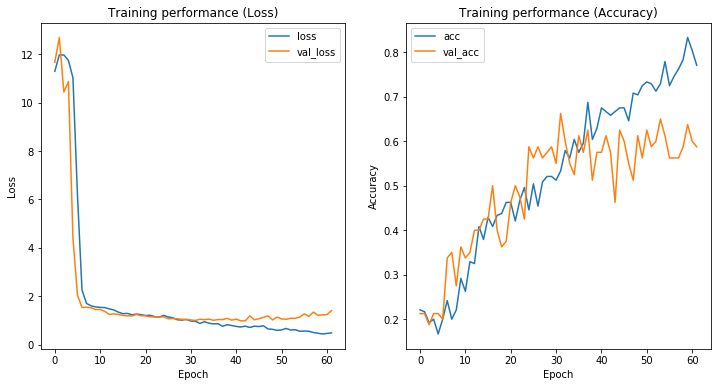

In [43]:
#Learning curve
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].set_title('Training performance (Loss)')
ax[0].plot(history.epoch, history.history['loss'], label='loss')
ax[0].plot(history.epoch, history.history['val_loss'], label='val_loss')
ax[0].set(xlabel='Epoch', ylabel='Loss')
ax[0].legend()

ax[1].set_title('Training performance (Accuracy)')
ax[1].plot(history.epoch, history.history['acc'], label='acc')
ax[1].plot(history.epoch, history.history['val_acc'], label='val_acc')
ax[1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1].legend(loc='best')

plt.savefig('./mfcc_cnn.pdf', dpi=600)

## 4. Graph

## Make graph

In [52]:
'''
os.mkdir('./Images')
for a in range(0,len(Datas)):
    os.mkdir('./Images/LV'+str(a))
'''

"\nos.mkdir('./Images')\nfor a in range(0,len(Datas)):\n    os.mkdir('./Images/LV'+str(a))\n"

In [53]:
for a in range(0,len(Datas)):
    for b in range(0,len(Datas[a])):
        fig = plt.figure()
        plt.plot(Datas[a][b],antialiased=False,color='black',linewidth=0.5)
        plt.axis([0,8800,-1,1])
        plt.tick_params(labelbottom=False,labelleft=False,labelright=False,labeltop=False)
        plt.tick_params(bottom=False,left=False,right=False,top=False)
        plt.box(False)
        plt.savefig('./Images/LV'+str(a)+'/'+str(b+1)+'.png')
        plt.close(fig)

## 4-1. CNN(Convolutional Neural Network)

## Import and save images

In [54]:
data = []
labels = []
levels=os.listdir("./Images/")
for a in levels:
    try:
        if not a.startswith('.'):
            files = os.listdir("./Images/"+a)
            for b in files:
                try:
                    if not b.startswith('.'):
                        path_to_file = os.path.join("./Images/"+a, b)
                        image=cv2.imread(path_to_file)
                        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                        image_from_array = Image.fromarray(gray)
                        data.append(np.array(image_from_array))
                        labels.append(int(a[2]))
                except AttributeError:
                    print("")
    except AttributeError:
        print("")

In [55]:
Graph=np.array(data)
labels=np.array(labels)

In [56]:
np.save("./npy/Graph",Graph)
np.save("./npy/labels",labels)

## Load Images

In [3]:
Graph=np.load("./npy/Graph.npy")
labels=np.load("./npy/labels.npy")

## Data preprocessing

In [4]:
s=np.arange(Graph.shape[0])
np.random.shuffle(s)
Graph=Graph[s]
labels=labels[s]

In [5]:
num_classes=len(np.unique(labels))
len_data=len(Graph)

In [6]:
(x_train,x_test)=Graph[(int)(0.1*len_data):],Graph[:(int)(0.1*len_data)]
x_train = x_train.astype('float32')/255 # As we are working on image data we are normalizing data by divinding 255.
x_test = x_test.astype('float32')/255
train_len=len(x_train)
test_len=len(x_test)

In [7]:
(y_train,y_test)=labels[(int)(0.1*len_data):],labels[:(int)(0.1*len_data)]

# Visualization of data 

In [8]:
#preparing label name
label = np.array([
    'Lv0',
    'Lv1',
    'Lv2',
    'Lv3',
    'Lv4'])

In [9]:
#Store 10 images for each label
img_list = []
for for_1 in range(5):
    choice_idx = np.random.choice(np.where(y_test == for_1)[0], 5)
    img_list.append(x_test[choice_idx])

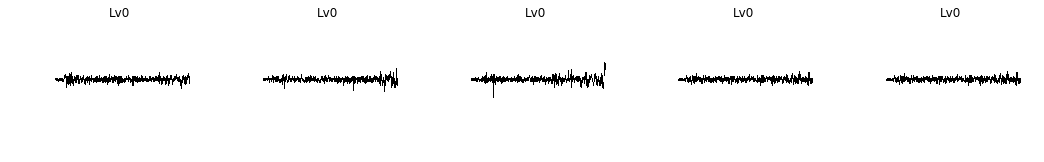

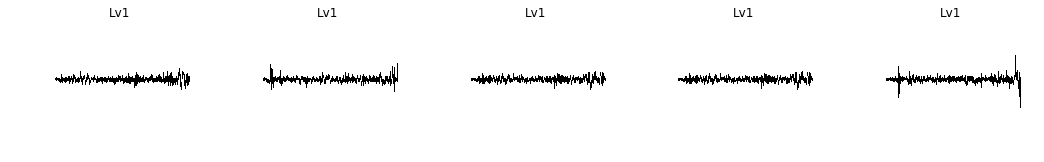

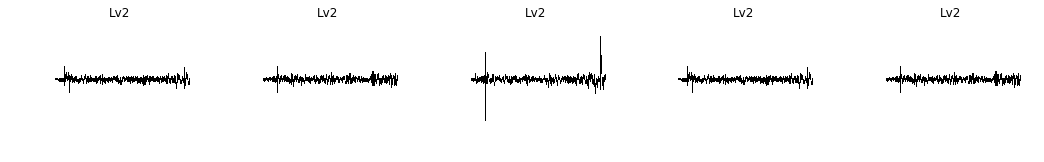

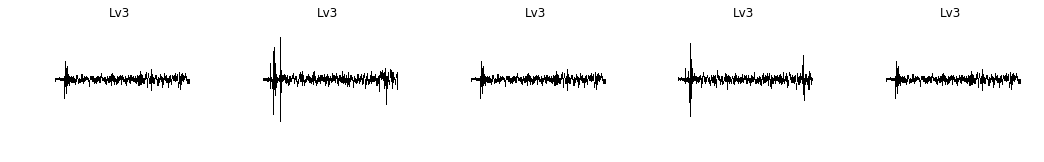

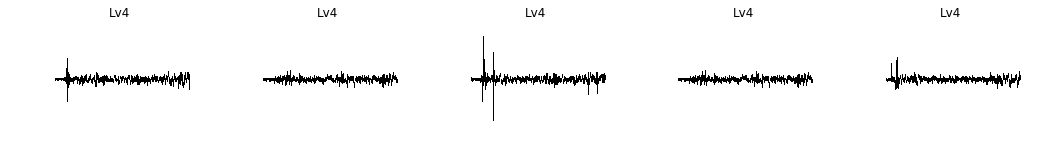

In [10]:
# Visualization of data
for for_1 in range(5):
    fig, ax = plt.subplots(1, 5, figsize=(18, 8))
    for for_2 in range(5):
        ax[for_2].imshow(img_list[for_1][for_2],cmap='gray') #Outputs the nth and subsequent test data with the value of for_2 + n
        ax[for_2].set_title(label[for_1])
        ax[for_2].axis('off')

In [11]:
y_train=keras.utils.to_categorical(y_train,num_classes)
y_test=keras.utils.to_categorical(y_test,num_classes)

In [12]:
img_rows, img_cols = 288,432
img_channels = 1
# Adjustment of input type of dimension number due to difference of backend

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [13]:
model2 = Sequential()
model2.add(Conv2D(32, kernel_size=(12, 12), activation="relu", input_shape=input_shape))
model2.add(MaxPooling2D(pool_size=(6,6)))
model2.add(Conv2D(32, kernel_size=(6, 6), activation="relu"))
model2.add(MaxPooling2D(pool_size=(3,3)))
model2.add(Conv2D(64, kernel_size=(4, 4), activation="relu"))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(5, activation='softmax'))

In [14]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 277, 421, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 70, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 65, 32)        36896     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 21, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 18, 64)        32832     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 9, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2880)              0         
__________

## Set model optimization function and error function

In [15]:
from keras.optimizers import SGD, Adadelta, Adam, RMSprop

# model.compile(loss='categorical_crossentropy', 
#               optimizer='SGD', 
#               metrics=['accuracy'])
model2.compile(loss="categorical_crossentropy", # 誤差(損失)関数
             optimizer="adam", # 最適化関数
             metrics=["accuracy"] # 評価指標
             )

## Save model and parameters

In [16]:
#Save model in JSON format
json_string = model2.to_json()
open('./sound.json', 'w').write(json_string)

3677

In [17]:
#Save initial weight
model2.save_weights('./sound.hdf5', overwrite=True)

## Reading models and calling parameters

In [18]:
# from keras.models import model_from_json, model_from_yaml
# #Calling models saved in JSON format
# json_string = open('./sound.json', 'r').read()
# model = model_from_json(json_string)
# model.load_weights('./sound.hdf5')

## Learning

In [19]:
#See progress of learning at TensorBoard
tb_cb = keras.callbacks.TensorBoard(log_dir='./', histogram_freq=1)

# If the validation loss decreases, save the model for each epoch
cp_cb = keras.callbacks.ModelCheckpoint(filepath='./sound.hdf5', 
                                        monitor='val_loss', 
                                        verbose=1, 
                                        save_best_only=True, 
                                        mode='auto')

# If the validation loss rises for 5 epochs in a row, the run is aborted
es_cb = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=5, 
                                      verbose=0, 
                                      mode='auto')

cbks = [tb_cb, cp_cb, es_cb]

In [20]:
#Perform learning
#The value of loss function in learning is stored in history.history
history2 = model2.fit(x_train, y_train,
                    batch_size=32,  #128 datas are randomly obtained
                    nb_epoch=5, #Number of trials
                    verbose=1,
                    validation_data=(x_test, y_test),
                    validation_split=0.1,
                    callbacks=cbks
                    )

/Users/jaejinan/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 66s 183ms/step - loss: 1.6388 - acc: 0.1833 - val_loss: 1.6156 - val_acc: 0.3250

Epoch 00001: val_loss improved from inf to 1.61560, saving model to ./sound.hdf5
Epoch 2/5
360/360 [==============================] - 67s 185ms/step - loss: 1.6015 - acc: 0.2000 - val_loss: 1.6331 - val_acc: 0.0750

Epoch 00002: val_loss did not improve from 1.61560
Epoch 3/5
360/360 [==============================] - 65s 180ms/step - loss: 1.5371 - acc: 0.2417 - val_loss: 1.5103 - val_acc: 0.2500

Epoch 00003: val_loss improved from 1.61560 to 1.51026, saving model to ./sound.hdf5
Epoch 4/5
360/360 [==============================] - 64s 179ms/step - loss: 1.3920 - acc: 0.3889 - val_loss: 1.3553 - val_acc: 0.4500

Epoch 00004: val_loss improved from 1.51026 to 1.35532, saving model to ./sound.hdf5
Epoch 5/5
360/360 [==============================] - 65s 180ms/step - loss: 1.2863 - acc: 0.4111 - val_loss: 1.21

## Calling the best parameter

In [21]:
model2.load_weights('./sound.hdf5')

## Evaluation of learning result

In [22]:
#Evaluation value for test data
score = model2.evaluate(x_test, y_test, verbose=0)
print('Test score:', score[0]) #The value of the loss function
print('Test accuracy:', score[1]) #Accuracy (over 98%)

Test score: 1.2196760892868042
Test accuracy: 0.5


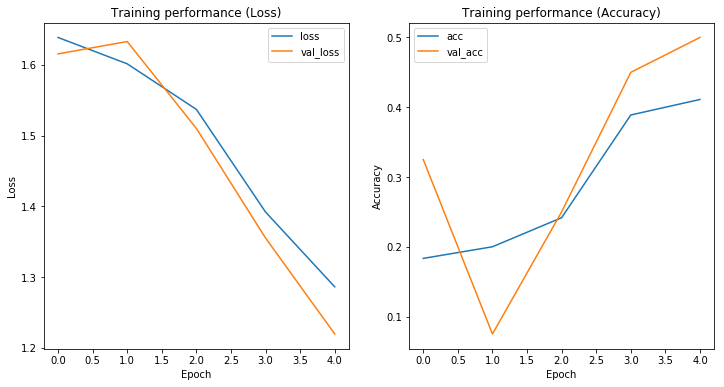

In [23]:
#Learning curve
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].set_title('Training performance (Loss)')
ax[0].plot(history2.epoch, history2.history['loss'], label='loss')
ax[0].plot(history2.epoch, history2.history['val_loss'], label='val_loss')
ax[0].set(xlabel='Epoch', ylabel='Loss')
ax[0].legend()

ax[1].set_title('Training performance (Accuracy)')
ax[1].plot(history2.epoch, history2.history['acc'], label='acc')
ax[1].plot(history2.epoch, history2.history['val_acc'], label='val_acc')
ax[1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1].legend(loc='best')

plt.savefig('./image_cnn.pdf', dpi=600)

## Predictive visualization

In [24]:
#Predicted value
#Store 10 images for each label
New_test = []
for for_1 in range(10):
    choice_idx = np.random.choice(np.where(y_test == (for_1%2))[0])
    New_test.append(x_test[choice_idx])
New_test = np.array(New_test)
# Estimate the label of the image
Y_test_pred = model2.predict(New_test)

In [25]:
New_test = New_test.reshape(New_test.shape[0], img_rows, img_cols)

In [1]:
#Data visualization
#The upper row is the correct label, and lower row is the guess label
fig, ax = plt.subplots(1, 10, figsize=(18, 8))
for for_1 in range(10):
    ax[for_1].imshow(New_test[for_1],cmap='gray') #Outputs the nth and subsequent test data with the value of for_2 + n
    ax[for_1].set_title("real:"+str(label[np.argmax(y_test[for_1])])+"\npred:"+str(label[np.argmax(Y_test_pred[for_1])]))
    ax[for_1].axis('off')

NameError: name 'plt' is not defined

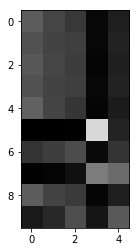

In [27]:
#Predictive visualization
#Numerals of images passed by Y axis, and X axis is estimated by neural network
plt.imshow(Y_test_pred[:10], cmap='gray', interpolation='nearest', vmin=0, vmax=1) #Y_test_predの範囲を変えることで予測の場所を変更できる

## 4-2. Graph Division3

In [7]:

os.mkdir('./Images2')
for a in range(0,len(Datas)):
    os.mkdir('./Images2/LV'+str(a))


In [8]:
for a in range(0,len(Datas)):
    for b in range(0,len(Datas[a])):
        for c in range(0,3):
            fig = plt.figure()
            plt.plot(Datas[a][b][1100*c:1100*c+6599],antialiased=False,color='black',linewidth=0.5)
            plt.axis([0,6600,-1,1])
            plt.tick_params(labelbottom=False,labelleft=False,labelright=False,labeltop=False)
            plt.tick_params(bottom=False,left=False,right=False,top=False)
            plt.box(False)
            plt.savefig('./Images2/LV'+str(a)+'/'+str(b+1)+'_'+str(c+1)+'.png')
            plt.close(fig)

## Import and save images

In [6]:
data = []
labels = []
levels=os.listdir("./Images2/")
for a in levels:
    try:
        if not a.startswith('.'):
            files = os.listdir("./Images2/"+a)
            for b in files:
                try:
                    if not b.startswith('.'):
                        path_to_file = os.path.join("./Images2/"+a, b)
                        image=cv2.imread(path_to_file)
                        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                        image_from_array = Image.fromarray(gray)
                        data.append(np.array(image_from_array))
                        labels.append(int(a[2]))
                except AttributeError:
                    print("")
    except AttributeError:
        print("")

In [7]:
Graph3=np.array(data)
labels3=np.array(labels)

In [8]:
np.save("./npy/Graph3",Graph3)
np.save("./npy/labels3",labels3)

## Load Images

In [3]:
Graph3=np.load("./npy/Graph3.npy")
labels3=np.load("./npy/labels3.npy")

## Data preprocessing

In [4]:
s=np.arange(Graph3.shape[0])
s=s.reshape((400, 3))
np.random.shuffle(s)
s=s.reshape(Graph3.shape[0])
Graph3=Graph3[s]
labels3=labels3[s]

In [5]:
num_classes=len(np.unique(labels3))
len_data=len(Graph3)

In [6]:
(x_train,x_val,x_test)=Graph3[(int)(0.2*len_data):],Graph3[:(int)(0.1*len_data)],Graph3[(int)(0.1*len_data):(int)(0.2*len_data)]
x_train = x_train.astype('float32')/255 # As we are working on image data we are normalizing data by divinding 255.
x_val = x_val.astype('float32')/255
x_test = x_test.astype('float32')/255
train_len=len(x_train)
test_len=len(x_test)

In [7]:
(y_train,y_val,y_test)=labels3[(int)(0.2*len_data):],labels3[:(int)(0.1*len_data)],labels3[(int)(0.1*len_data):(int)(0.2*len_data)]

# Visualization of data 

In [8]:
#preparing label name
label = np.array([
    'Lv0',
    'Lv1',
    'Lv2',
    'Lv3',
    'Lv4'])

In [9]:
#Store 10 images for each label
img_list = []
for for_1 in range(5):
    choice_idx = np.random.choice(np.where(y_test == for_1)[0], 5)
    img_list.append(x_test[choice_idx])

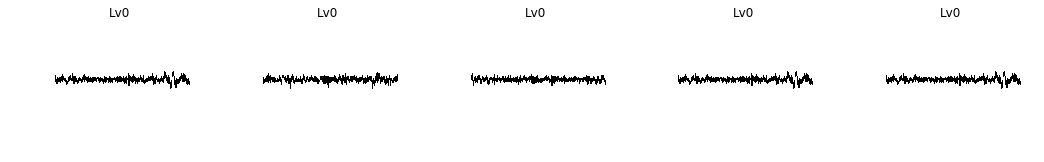

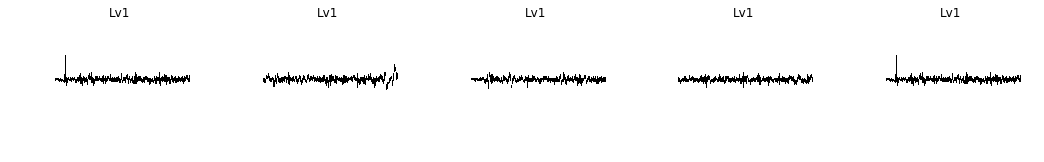

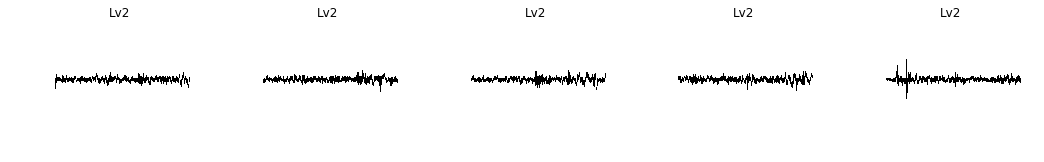

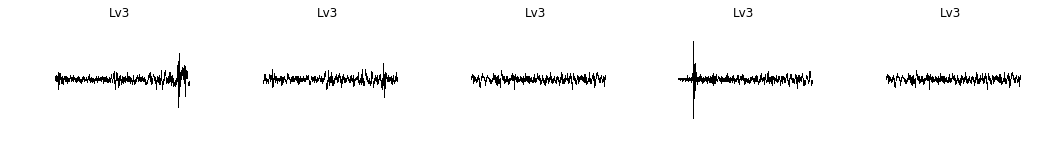

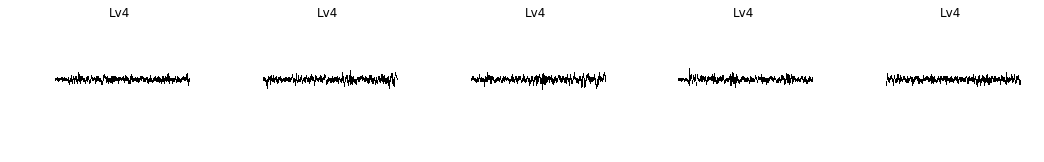

In [10]:
# Visualization of data
for for_1 in range(5):
    fig, ax = plt.subplots(1, 5, figsize=(18, 8))
    for for_2 in range(5):
        ax[for_2].imshow(img_list[for_1][for_2],cmap='gray') #Outputs the nth and subsequent test data with the value of for_2 + n
        ax[for_2].set_title(label[for_1])
        ax[for_2].axis('off')

In [11]:
y_train=keras.utils.to_categorical(y_train,num_classes)
y_val=keras.utils.to_categorical(y_val,num_classes)
y_test=keras.utils.to_categorical(y_test,num_classes)

In [12]:
img_rows, img_cols = 288,432
img_channels = 1
# Adjustment of input type of dimension number due to difference of backend

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_val = x_val.reshape(x_val.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [13]:
model3 = Sequential()
model3.add(Conv2D(32, kernel_size=(8, 8), activation="relu", input_shape=input_shape))
model3.add(MaxPooling2D(pool_size=(4,4)))
model3.add(Conv2D(32, kernel_size=(6, 6), activation="relu"))
model3.add(MaxPooling2D(pool_size=(3,3)))
model3.add(Conv2D(64, kernel_size=(6, 6), activation="relu"))
model3.add(MaxPooling2D(pool_size=(3,3)))
model3.add(Conv2D(64, kernel_size=(4, 4), activation="relu"))
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Flatten())
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(5, activation='softmax'))

In [14]:
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 281, 425, 32)      2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 70, 106, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 65, 101, 32)       36896     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 21, 33, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 28, 64)        73792     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 9, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 6, 64)          65600     
__________

## Set model optimization function and error function

In [15]:
from keras.optimizers import SGD, Adadelta, Adam, RMSprop

# model.compile(loss='categorical_crossentropy', 
#               optimizer='SGD', 
#               metrics=['accuracy'])
model3.compile(loss="categorical_crossentropy", # 誤差(損失)関数
             optimizer="adam", # 最適化関数
             metrics=["accuracy"] # 評価指標
             )

## Save model and parameters

In [16]:
#Save model in JSON format
json_string = model3.to_json()
open('./sound3.json', 'w').write(json_string)

4446

In [17]:
#Save initial weight
model3.save_weights('./sound3.hdf5', overwrite=True)

## Reading models and calling parameters

In [18]:
# from keras.models import model_from_json, model_from_yaml
# #Calling models saved in JSON format
# json_string = open('./sound.json', 'r').read()
# model = model_from_json(json_string)
# model.load_weights('./sound.hdf5')

## Learning

In [19]:
#See progress of learning at TensorBoard
tb_cb = keras.callbacks.TensorBoard(log_dir='./', histogram_freq=1)

# If the validation loss decreases, save the model for each epoch
cp_cb = keras.callbacks.ModelCheckpoint(filepath='./sound3.hdf5', 
                                        monitor='val_loss', 
                                        verbose=1, 
                                        save_best_only=True, 
                                        mode='auto')

# If the validation loss rises for 5 epochs in a row, the run is aborted
es_cb = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=5, 
                                      verbose=0, 
                                      mode='auto')

cbks = [tb_cb, cp_cb, es_cb]

In [20]:
#Perform learning
#The value of loss function in learning is stored in history.history
history3 = model3.fit(x_train, y_train,
                    batch_size=32,  #128 datas are randomly obtained
                    nb_epoch=50, #Number of trials
                    verbose=1,
                    validation_data=(x_val, y_val),
                    callbacks=cbks
                    )

/Users/jaejinan/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Train on 960 samples, validate on 120 samples
Epoch 1/50
960/960 [==============================] - 104s 108ms/step - loss: 1.6170 - acc: 0.1958 - val_loss: 1.6092 - val_acc: 0.1500

Epoch 00001: val_loss improved from inf to 1.60923, saving model to ./sound.hdf5
Epoch 2/50
960/960 [==============================] - 104s 108ms/step - loss: 1.6095 - acc: 0.2073 - val_loss: 1.6097 - val_acc: 0.2000

Epoch 00002: val_loss did not improve from 1.60923
Epoch 3/50
960/960 [==============================] - 107s 111ms/step - loss: 1.6087 - acc: 0.1969 - val_loss: 1.6065 - val_acc: 0.1500

Epoch 00003: val_loss improved from 1.60923 to 1.60651, saving model to ./sound.hdf5
Epoch 4/50
960/960 [==============================] - 101s 106ms/step - loss: 1.5567 - acc: 0.2396 - val_loss: 1.4918 - val_acc: 0.3667

Epoch 00004: val_loss improved from 1.60651 to 1.49180, saving model to ./sound.hdf5
Epoch 5/50
960/960 [==============================] - 100s 104ms/step - loss: 1.3858 - acc: 0.3979 - val

## Calling the best parameter

In [21]:
model3.load_weights('./sound3.hdf5')

## Evaluation of learning result

In [22]:
#Evaluation value for test data
score = model3.evaluate(x_test, y_test, verbose=0)
print('Test score:', score[0]) #The value of the loss function
print('Test accuracy:', score[1]) #Accuracy (over 98%)

Test score: 0.9449905594189961
Test accuracy: 0.574999996026357


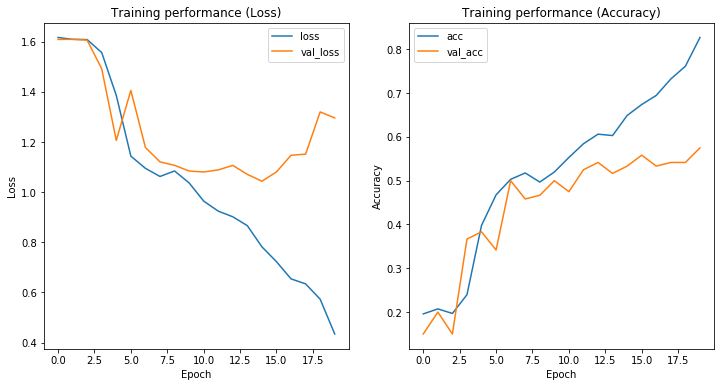

In [23]:
#Learning curve
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].set_title('Training performance (Loss)')
ax[0].plot(history3.epoch, history3.history['loss'], label='loss')
ax[0].plot(history3.epoch, history3.history['val_loss'], label='val_loss')
ax[0].set(xlabel='Epoch', ylabel='Loss')
ax[0].legend()

ax[1].set_title('Training performance (Accuracy)')
ax[1].plot(history3.epoch, history3.history['acc'], label='acc')
ax[1].plot(history3.epoch, history3.history['val_acc'], label='val_acc')
ax[1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1].legend(loc='best')

plt.savefig('./3image_cnn.pdf', dpi=600)

## Predictive visualization

In [37]:
Y_test_pred_pr = model3.predict(x_test)

count=0
cou = 0
for for_1 in range(0,int(len(x_test)/3)):
    count = count + 1
    if(label[np.argmax(y_test[3*for_1])] == label[np.argmax(Y_test_pred_pr[3*for_1]+Y_test_pred_pr[3*for_1+1]+Y_test_pred_pr[3*for_1+2])]):
        cou = cou + 1

print('Test accuracy:',cou/count)

Test accuracy: 0.6923076923076923


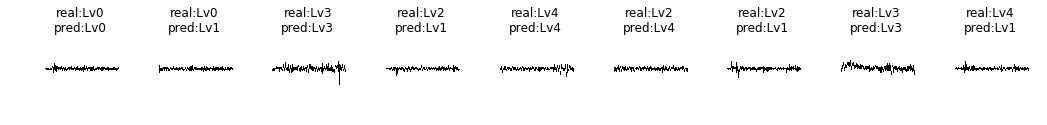

In [38]:
#Data visualization
#The upper row is the correct label, and lower row is the guess label
x_test_re = x_test.reshape(x_test.shape[0], img_rows, img_cols)
fig, ax = plt.subplots(1, 9, figsize=(18, 8))
for for_1 in range(0,9):
    ax[for_1].imshow(x_test_re[3*for_1],cmap='gray') #Outputs the nth and subsequent test data with the value of for_2 + n
    ax[for_1].set_title("real:"+str(label[np.argmax(y_test[3*for_1])])+"\npred:"+str(label[np.argmax(Y_test_pred_pr[3*for_1]+Y_test_pred_pr[3*for_1+1]+Y_test_pred_pr[3*for_1+2])]))
    ax[for_1].axis('off')

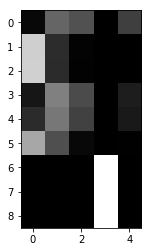

In [39]:
#Predictive visualization
#Numerals of images passed by Y axis, and X axis is estimated by neural network
plt.imshow(Y_test_pred[:10], cmap='gray', interpolation='nearest', vmin=0, vmax=1) #Y_test_predの範囲を変えることで予測の場所を変更できる

## 4-3. Graph Division5

In [4]:

os.mkdir('./Images3')
for a in range(0,len(Datas)):
    os.mkdir('./Images3/LV'+str(a))


In [6]:
for a in range(0,len(Datas)):
    for b in range(0,len(Datas[a])):
        for c in range(0,5):
            fig = plt.figure()
            plt.plot(Datas[a][b][550*c:550*c+6599],antialiased=False,color='black',linewidth=0.5)
            plt.axis([0,6600,-1,1])
            plt.tick_params(labelbottom=False,labelleft=False,labelright=False,labeltop=False)
            plt.tick_params(bottom=False,left=False,right=False,top=False)
            plt.box(False)
            plt.savefig('./Images3/LV'+str(a)+'/'+str(b+1)+'_'+str(c+1)+'.png')
            plt.close(fig)

## Import and save images

In [9]:
data = []
labels = []
levels=os.listdir("./Images3/")
for a in levels:
    try:
        if not a.startswith('.'):
            files = os.listdir("./Images3/"+a)
            for b in files:
                try:
                    if not b.startswith('.'):
                        path_to_file = os.path.join("./Images3/"+a, b)
                        image=cv2.imread(path_to_file)
                        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                        image_from_array = Image.fromarray(gray)
                        data.append(np.array(image_from_array))
                        labels.append(int(a[2]))
                except AttributeError:
                    print("")
    except AttributeError:
        print("")

In [10]:
Graph5=np.array(data)
labels5=np.array(labels)

In [11]:
np.save("./npy/Graph5",Graph5)
np.save("./npy/labels5",labels5)

## Load Images

In [3]:
Graph5=np.load("./npy/Graph5.npy")
labels5=np.load("./npy/labels5.npy")

## Data preprocessing

In [4]:
s=np.arange(Graph5.shape[0])
s=s.reshape((400, 5))
np.random.shuffle(s)
s=s.reshape(Graph5.shape[0])
Graph5=Graph5[s]
labels5=labels5[s]

In [5]:
num_classes=len(np.unique(labels5))
len_data=len(Graph5)

In [6]:
(x_train,x_val,x_test)=Graph5[(int)(0.2*len_data):],Graph5[:(int)(0.1*len_data)],Graph5[(int)(0.1*len_data):(int)(0.2*len_data)]
x_train = x_train.astype('float32')/255 # As we are working on image data we are normalizing data by divinding 255.
x_val = x_val.astype('float32')/255
x_test = x_test.astype('float32')/255
train_len=len(x_train)
test_len=len(x_test)

In [7]:
(y_train,y_val,y_test)=labels5[(int)(0.2*len_data):],labels5[:(int)(0.1*len_data)],labels5[(int)(0.1*len_data):(int)(0.2*len_data)]

# Visualization of data 

In [8]:
#preparing label name
label = np.array([
    'Lv0',
    'Lv1',
    'Lv2',
    'Lv3',
    'Lv4'])

In [9]:
#Store 10 images for each label
img_list = []
for for_1 in range(5):
    choice_idx = np.random.choice(np.where(y_test == for_1)[0], 5)
    img_list.append(x_test[choice_idx])

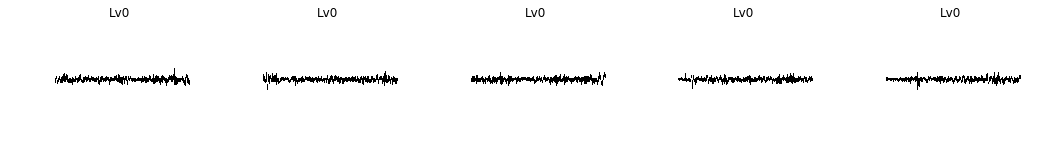

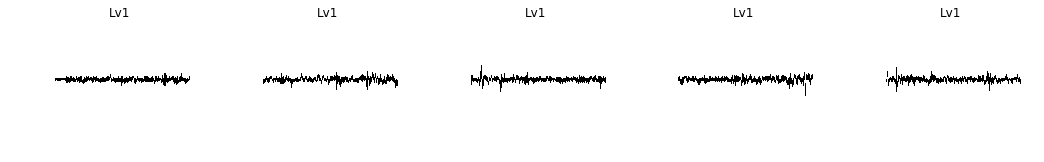

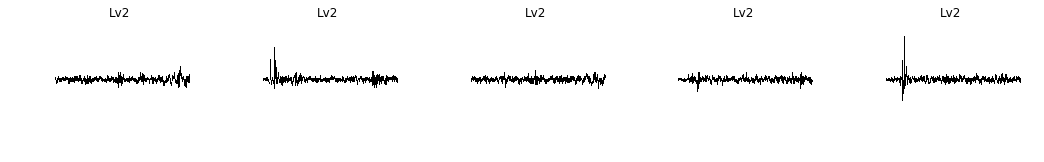

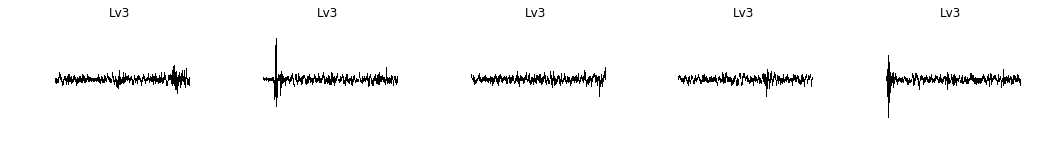

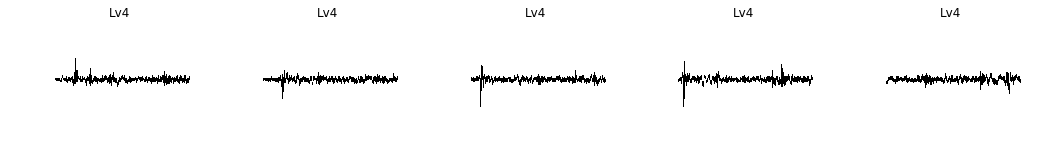

In [10]:
# Visualization of data
for for_1 in range(5):
    fig, ax = plt.subplots(1, 5, figsize=(18, 8))
    for for_2 in range(5):
        ax[for_2].imshow(img_list[for_1][for_2],cmap='gray') #Outputs the nth and subsequent test data with the value of for_2 + n
        ax[for_2].set_title(label[for_1])
        ax[for_2].axis('off')

In [11]:
y_train=keras.utils.to_categorical(y_train,num_classes)
y_val=keras.utils.to_categorical(y_val,num_classes)
y_test=keras.utils.to_categorical(y_test,num_classes)

In [12]:
img_rows, img_cols = 288,432
img_channels = 1
# Adjustment of input type of dimension number due to difference of backend

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_val = x_val.reshape(x_val.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [13]:
model4 = Sequential()
model4.add(Conv2D(32, kernel_size=(8, 8), activation="relu", input_shape=input_shape))
model4.add(MaxPooling2D(pool_size=(4,4)))
model4.add(Conv2D(32, kernel_size=(6, 6), activation="relu"))
model4.add(MaxPooling2D(pool_size=(3,3)))
model4.add(Conv2D(64, kernel_size=(6, 6), activation="relu"))
model4.add(MaxPooling2D(pool_size=(3,3)))
model4.add(Conv2D(64, kernel_size=(4, 4), activation="relu"))
model4.add(MaxPooling2D(pool_size=(2,2)))

model4.add(Flatten())
model4.add(Dense(256, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(5, activation='softmax'))

In [14]:
model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 281, 425, 32)      2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 70, 106, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 65, 101, 32)       36896     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 21, 33, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 28, 64)        73792     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 9, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 6, 64)          65600     
__________

## Set model optimization function and error function

In [15]:
from keras.optimizers import SGD, Adadelta, Adam, RMSprop

# model.compile(loss='categorical_crossentropy', 
#               optimizer='SGD', 
#               metrics=['accuracy'])
model4.compile(loss="categorical_crossentropy", # 誤差(損失)関数
             optimizer="adam", # 最適化関数
             metrics=["accuracy"] # 評価指標
             )

## Save model and parameters

In [16]:
#Save model in JSON format
json_string = model4.to_json()
open('./sound5.json', 'w').write(json_string)

4446

In [17]:
#Save initial weight
model4.save_weights('./sound5.hdf5', overwrite=True)

## Reading models and calling parameters

In [18]:
# from keras.models import model_from_json, model_from_yaml
# #Calling models saved in JSON format
# json_string = open('./sound.json', 'r').read()
# model = model_from_json(json_string)
# model.load_weights('./sound.hdf5')

## Learning

In [19]:
#See progress of learning at TensorBoard
tb_cb = keras.callbacks.TensorBoard(log_dir='./', histogram_freq=1)

# If the validation loss decreases, save the model for each epoch
cp_cb = keras.callbacks.ModelCheckpoint(filepath='./sound5.hdf5', 
                                        monitor='val_loss', 
                                        verbose=1, 
                                        save_best_only=True, 
                                        mode='auto')

# If the validation loss rises for 5 epochs in a row, the run is aborted
es_cb = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=5, 
                                      verbose=0, 
                                      mode='auto')

cbks = [tb_cb, cp_cb, es_cb]

In [20]:
#Perform learning
#The value of loss function in learning is stored in history.history
history4 = model4.fit(x_train, y_train,
                    batch_size=32,  #128 datas are randomly obtained
                    nb_epoch=50, #Number of trials
                    verbose=1,
                    validation_data=(x_val, y_val),
                    callbacks=cbks
                    )

/Users/jaejinan/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1600 samples, validate on 200 samples
Epoch 1/50
1600/1600 [==============================] - 182s 114ms/step - loss: 1.6117 - acc: 0.2044 - val_loss: 1.6211 - val_acc: 0.1250

Epoch 00001: val_loss improved from inf to 1.62110, saving model to ./sound5.hdf5
Epoch 2/50
1600/1600 [==============================] - 184s 115ms/step - loss: 1.6084 - acc: 0.2225 - val_loss: 1.6162 - val_acc: 0.1250

Epoch 00002: val_loss improved from 1.62110 to 1.61616, saving model to ./sound5.hdf5
Epoch 3/50
1600/1600 [==============================] - 175s 109ms/step - loss: 1.5897 - acc: 0.2288 - val_loss: 1.3717 - val_acc: 0.2950

Epoch 00003: val_loss improved from 1.61616 to 1.37165, saving model to ./sound5.hdf5
Epoch 4/50
1600/1600 [==============================] - 168s 105ms/step - loss: 1.5806 - acc: 0.2662 - val_loss: 1.3932 - val_acc: 0.3250

Epoch 00004: val_loss did not improve from 1.37165
Epoch 5/50
1600/1600 [==============================] - 178s 111ms/step - loss: 1.2810 - acc

## Calling the best parameter

In [21]:
model4.load_weights('./sound5.hdf5')

## Evaluation of learning result

In [22]:
#Evaluation value for test data
score = model4.evaluate(x_test, y_test, verbose=0)
print('Test score:', score[0]) #The value of the loss function
print('Test accuracy:', score[1]) #Accuracy (over 98%)

Test score: 1.0308395379781723
Test accuracy: 0.695


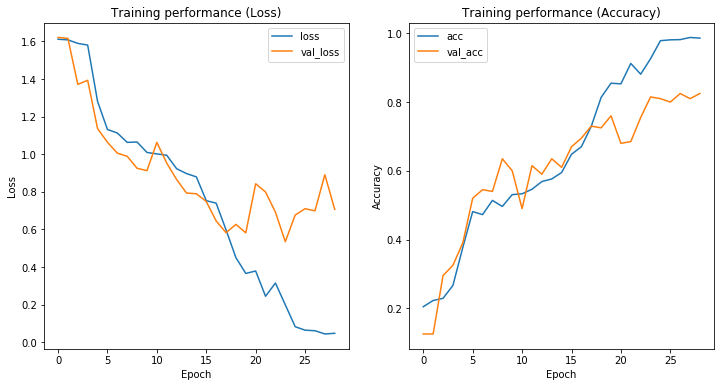

In [23]:
#Learning curve
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].set_title('Training performance (Loss)')
ax[0].plot(history4.epoch, history4.history['loss'], label='loss')
ax[0].plot(history4.epoch, history4.history['val_loss'], label='val_loss')
ax[0].set(xlabel='Epoch', ylabel='Loss')
ax[0].legend()

ax[1].set_title('Training performance (Accuracy)')
ax[1].plot(history4.epoch, history4.history['acc'], label='acc')
ax[1].plot(history4.epoch, history4.history['val_acc'], label='val_acc')
ax[1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1].legend(loc='best')

plt.savefig('./5image_cnn.pdf', dpi=600)

## Predictive visualization

In [24]:
Y_test_pred_pr = model4.predict(x_test)

count=0
cou = 0
for for_1 in range(0,int(len(x_test)/5)):
    count = count + 1
    if(label[np.argmax(y_test[5*for_1])] == label[np.argmax(Y_test_pred_pr[5*for_1]+Y_test_pred_pr[5*for_1+1]+Y_test_pred_pr[5*for_1+2]+Y_test_pred_pr[5*for_1+3]+Y_test_pred_pr[5*for_1+4])]):
        cou = cou + 1

print('Test accuracy:',cou/count)        

Test accuracy: 0.85


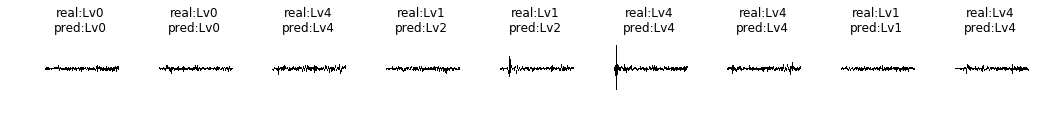

In [25]:
#Data visualization
#The upper row is the correct label, and lower row is the guess label
x_test_re = x_test.reshape(x_test.shape[0], img_rows, img_cols)
fig, ax = plt.subplots(1, 9, figsize=(18, 8))
for for_1 in range(0,9):
    ax[for_1].imshow(x_test_re[5*for_1],cmap='gray') #Outputs the nth and subsequent test data with the value of for_2 + n
    ax[for_1].set_title("real:"+str(label[np.argmax(y_test[5*for_1])])+"\npred:"+str(label[np.argmax(Y_test_pred_pr[5*for_1]+Y_test_pred_pr[5*for_1+1]+Y_test_pred_pr[5*for_1+2]+Y_test_pred_pr[5*for_1+3]+Y_test_pred_pr[5*for_1+4])]))
    ax[for_1].axis('off')

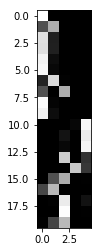

In [26]:
#Predictive visualization
#Numerals of images passed by Y axis, and X axis is estimated by neural network
plt.imshow(Y_test_pred_pr[:20], cmap='gray', interpolation='nearest', vmin=0, vmax=1) #Y_test_predの範囲を変えることで予測の場所を変更できる

In [30]:
for for_1 in range(0,int(len(x_test)/5)):
    print("real:",label[np.argmax(y_test[5*for_1])],"pred:",label[np.argmax(Y_test_pred_pr[5*for_1]+Y_test_pred_pr[5*for_1+1]+Y_test_pred_pr[5*for_1+2]+Y_test_pred_pr[5*for_1+3]+Y_test_pred_pr[5*for_1+4])])

real: Lv0 pred: Lv0
real: Lv0 pred: Lv0
real: Lv4 pred: Lv4
real: Lv1 pred: Lv2
real: Lv1 pred: Lv2
real: Lv4 pred: Lv4
real: Lv4 pred: Lv4
real: Lv1 pred: Lv1
real: Lv4 pred: Lv4
real: Lv2 pred: Lv2
real: Lv3 pred: Lv3
real: Lv2 pred: Lv2
real: Lv1 pred: Lv1
real: Lv0 pred: Lv0
real: Lv4 pred: Lv4
real: Lv4 pred: Lv4
real: Lv4 pred: Lv4
real: Lv0 pred: Lv0
real: Lv3 pred: Lv3
real: Lv3 pred: Lv3
real: Lv4 pred: Lv4
real: Lv0 pred: Lv1
real: Lv0 pred: Lv0
real: Lv4 pred: Lv4
real: Lv0 pred: Lv0
real: Lv1 pred: Lv1
real: Lv1 pred: Lv1
real: Lv2 pred: Lv2
real: Lv1 pred: Lv1
real: Lv0 pred: Lv1
real: Lv3 pred: Lv3
real: Lv0 pred: Lv0
real: Lv4 pred: Lv4
real: Lv0 pred: Lv1
real: Lv1 pred: Lv1
real: Lv4 pred: Lv4
real: Lv2 pred: Lv4
real: Lv0 pred: Lv0
real: Lv1 pred: Lv1
real: Lv3 pred: Lv3


In [32]:
from sklearn.metrics import confusion_matrix
real = []
pred = []

for for_1 in range(0,int(len(x_test)/5)):
    real.append(label[np.argmax(y_test[5*for_1])])
    pred.append(label[np.argmax(Y_test_pred_pr[5*for_1]+Y_test_pred_pr[5*for_1+1]+Y_test_pred_pr[5*for_1+2]+Y_test_pred_pr[5*for_1+3]+Y_test_pred_pr[5*for_1+4])])
    
print(confusion_matrix(real, pred))

[[ 8  3  0  0  0]
 [ 0  7  2  0  0]
 [ 0  0  3  0  1]
 [ 0  0  0  5  0]
 [ 0  0  0  0 11]]
